# Find the best location to open a fast food restaurant in New York
Couresa Data Science Course Final Assignment - Capstone Project
**************

In [1]:
# import libs
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

import folium 
import foursquare
from pandas.io.json import json_normalize

from pathlib import Path

Download from https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Rentals&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2020-10-01&area=Flatiron,Brooklyn%20Heights

In [2]:
#load the rent dataset for one bedroom
neighborhood_rent = pd.read_csv("./medianAskingRent_OneBd.csv")

neighborhood_rent = neighborhood_rent[neighborhood_rent['areaType'] == 'neighborhood' ]
neighborhood_rent['Borough'] = neighborhood_rent['Borough'].apply(lambda name : name.upper())
neighborhood_rent['areaName'] = neighborhood_rent['areaName'].apply(lambda name : name.upper())

neighborhood_rent['avg_rent']=neighborhood_rent[['2019-11','2019-12','2020-01','2020-02','2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10']].mean(axis=1)
neighborhood_rent = neighborhood_rent[['areaName','Borough', 'avg_rent']]

#calculate the average rent for each borough
borough_avg = neighborhood_rent.groupby('Borough')['avg_rent'].agg(np.mean)


#replace the nan with the average rent for that borough
def repl_nan_with_avg(row):
    if np.isnan(row['avg_rent']):
        row['avg_rent'] = borough_avg[row['Borough']]
    
    return row
    
neighborhood_rent = neighborhood_rent.apply(repl_nan_with_avg, axis = 1)
neighborhood_rent = neighborhood_rent[neighborhood_rent["areaName"] !='KEW GARDENS HILLS']


neighborhood_rent.head()

,areaName,Borough,avg_rent
5,ASTORIA,QUEENS,1954.833333
6,AUBURNDALE,QUEENS,1600.000000
7,BATH BEACH,BROOKLYN,1647.571429
8,BATTERY PARK CITY,MANHATTAN,3679.916667
9,BAY RIDGE,BROOKLYN,1726.750000


In [3]:
# download the longitude and latitude and save into a csv file so that do not need to download everytime

geolocator = Nominatim(user_agent="to_explorer")

def get_location(row):
    address = row["areaName"] + " " + row["Borough"] + " " + "NEW YORK"
    location = geolocator.geocode(address, timeout=None)
    
    if(location == None): 
        address = row["areaName"] + " NEW YORK"
        location = geolocator.geocode(address, timeout=None)
    
    if(location != None):
        row['latitude'] = location.latitude
        row['longitude'] = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, location.latitude, location.longitude))
    return row

rent_csv = Path('./neighborhood_rent.csv')

# check the venues data is explored and downloaded 
if( rent_csv.exists() ):
    print("neighborhood_rent.csv is exist, will not download data again.")
else:
    neighborhood_rent = neighborhood_rent.apply(get_location, axis = 1)

    neighborhood_rent = neighborhood_rent.reindex()
    neighborhood_rent.to_csv('./neighborhood_rent.csv')
    


neighborhood_rent.csv is exist, will not download data again.


In [4]:
neighborhood_rent = pd.read_csv('./neighborhood_rent.csv')

neighborhood_rent.head()


,Unnamed: 0,Borough,areaName,avg_rent,latitude,longitude
0,5,QUEENS,ASTORIA,1954.833333,40.772015,-73.930267
1,6,QUEENS,AUBURNDALE,1600.000000,40.761452,-73.789724
2,7,BROOKLYN,BATH BEACH,1647.571429,40.601850,-74.000501
3,8,MANHATTAN,BATTERY PARK CITY,3679.916667,40.711017,-74.016937
4,9,BROOKLYN,BAY RIDGE,1726.750000,40.633993,-74.014584


In [5]:
address = 'NEW YORK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NY are {}, {}.'.format(latitude, longitude))

# create map of Boston using latitude and longitude values of the neighborhoods
import folium 
map_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhood_rent['latitude'], neighborhood_rent['longitude'], neighborhood_rent['areaName']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
            
map_ny

The geograpical coordinate of NY are 40.7127281, -74.0060152.


In [6]:

# Please refer https://developer.foursquare.com/docs/resources/categories. 

vn_categories = {
    
    'Movie Theater': '4bf58dd8d48988d17f941735',
    'Playground': '4bf58dd8d48988d1e7941735',
    'Park': '4bf58dd8d48988d163941735',
    'Event Space': '4bf58dd8d48988d171941735',
    'General Entertainment': '4bf58dd8d48988d1f1931735',
    'Stadium' : '4bf58dd8d48988d184941735',
    'Amphitheater' :'56aa371be4b08b9a8d5734db',
    'School' : '4bf58dd8d48988d13b941735',
    'Pedestrian Plaza': '52e81612bcbc57f1066b7a25',
    'Office': '4bf58dd8d48988d124941735'
}

', ' .join([ cat for cat in vn_categories])

'Movie Theater, Playground, Park, Event Space, General Entertainment, Stadium, Amphitheater, School, Pedestrian Plaza, Office'

In [31]:
CLIENT_ID = 'HFKPGAAUBI2BYFTPOLTNWY3MD2ZIQ0NONMMIHNSQMCW1F2Q0' # your Foursquare ID
CLIENT_SECRET = 'SVXLBTOZKDQMTDJG1WCTC3NVJGUFVAN2E0B22UQTE2KZJXM1' # your Foursquare Secret
ACCESS_TOKEN = 'PUL4ED0UBZMEABGS5QJKMN40H44BQJEOFKTOYSOHEV031SKC' # your FourSquare Access Token

fs = foursquare.Foursquare( CLIENT_ID, CLIENT_SECRET)
RADIUS = 500 

def venues_nearby(latitude, longitude, category, category_list, neighborhoodName, verbose=True):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': RADIUS,
            'categoryId': category_list[category]
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Name','Latitude','Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = cols
    if( verbose ):
        print('{} "{}" venues are found within {}m of location {}'.format(len(df), category, RADIUS, neighborhoodName))
    return df

In [32]:
venues_csv = Path('./neighborhood_venues.csv')
df_venues = None

# check the venues data is explored and downloaded 
if( venues_csv.exists() ):
    neighborhood_venues = pd.read_csv('./neighborhood_venues.csv')
else:    
    neighborhood_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in vn_categories:
            df = venues_nearby(lat, lng, cat, vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_venues = neighborhood_venues.append(df, sort=True)
    neighborhood_venues.to_csv('neighborhood_venues.csv', index=False)

neighborhood_venues.head()    

,Average Rent,Category,Latitude,Longitude,Name,Neighborhood
0,1954.833333,Playground,40.770164,-73.927960,Van Alst Playground,ASTORIA
1,1954.833333,Playground,40.768286,-73.931094,Astoria Health Playground,ASTORIA
2,1954.833333,Park,40.772551,-73.937231,Astoria Houses Park,ASTORIA
3,1954.833333,Park,40.772891,-73.934521,Goodwill Park,ASTORIA
4,1954.833333,Event Space,40.771578,-73.926874,Renaissance Event Hall,ASTORIA


<AxesSubplot:xlabel='Venue Category'>

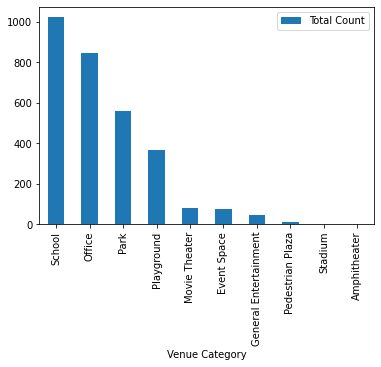

In [9]:
p= neighborhood_venues['Category'].value_counts().to_frame(name='Total Count')
p.index.name = 'Venue Category'
p.plot.bar(y='Total Count')


In [10]:
#check the number of venues for each neighborhood
df_groupby= neighborhood_venues.groupby('Neighborhood').count().reset_index()
df_groupby = df_groupby[['Neighborhood','Name']]
df_groupby= df_groupby.rename(columns={'Name':'VenueCount'})
df_groupby

,Neighborhood,VenueCount
0,ASTORIA,6
1,AUBURNDALE,6
2,BATH BEACH,9
3,BATTERY PARK CITY,56
4,BAY RIDGE,9
...,...,...
168,WINDSOR TERRACE,15
169,WOODHAVEN,8
170,WOODLAWN,2
171,WOODSIDE,16


In [11]:
# calculate the number of venus for each category for each neighborhood
neighborhood_venues_onehot = pd.get_dummies(neighborhood_venues[['Category']], prefix="", prefix_sep="")#one hot encoding
neighborhood_venues_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 
fixed_columns = [neighborhood_venues_onehot.columns[-1]] + list(neighborhood_venues_onehot.columns[:-1])
neighborhood_venues_onehot = neighborhood_venues_onehot[fixed_columns]
neighborhood_venues_onehot = neighborhood_venues_onehot.groupby('Neighborhood').sum().reset_index() 
neighborhood_venues_onehot.head()

,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium
0,ASTORIA,0,1,0,0,0,2,0,2,1,0
1,AUBURNDALE,0,0,0,1,1,0,0,1,3,0
2,BATH BEACH,0,0,0,0,1,1,0,1,6,0
3,BATTERY PARK CITY,0,1,0,1,30,10,4,3,7,0
4,BAY RIDGE,0,0,0,1,3,1,0,2,2,0


In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#find top 5 most common venues around each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns =[ 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Neighborhood'] = neighborhood_venues_onehot['Neighborhood']


for ind in np.arange(neighborhood_venues_onehot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_venues_onehot.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted['Average Rent'] = df_boston_nj['Average Rent']
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, df_groupby, how="left", left_on="Neighborhood", right_on="Neighborhood" )

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount
0,ASTORIA,Playground,Park,School,Event Space,Stadium,6
1,AUBURNDALE,School,Playground,Office,Movie Theater,Stadium,6
2,BATH BEACH,School,Playground,Park,Office,Stadium,9
3,BATTERY PARK CITY,Office,Park,School,Pedestrian Plaza,Playground,56
4,BAY RIDGE,Office,School,Playground,Park,Movie Theater,9


In [39]:
ff_vn_categories = {
    
    'Fast Food Restaurant': '4bf58dd8d48988d16e941735'
}

ff_venues_csv = Path('./neighborhood_fastfood_venues.csv')
neighborhood_ff_venues = None

# check the venues data is explored and downloaded 
if( ff_venues_csv.exists() ):
    neighborhood_ff_venues = pd.read_csv('./neighborhood_fastfood_venues.csv')
else:    
    neighborhood_ff_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in ff_vn_categories:
            df = venues_nearby(lat, lng, cat, ff_vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_ff_venues = neighborhood_ff_venues.append(df, sort=True)
    neighborhood_ff_venues.to_csv('neighborhood_fastfood_venues.csv', index=False)

neighborhood_ff_venues=neighborhood_ff_venues[["Neighborhood","Name"]].groupby("Neighborhood").count()    
neighborhood_ff_venues.head(10)    

,Name
Neighborhood,
EAST HARLEM,1
MIDTOWN EAST,1
MIDTOWN SOUTH,1
NOLITA,1
NORWOOD,1
WILLIAMSBRIDGE,1
